In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
from fastai import *
from fastai.imports import *
from fastai.tabular import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from merge_closest import merge_closest # https://pypi.org/project/merge_closest/ mimics vlookup

### Load Data

In [3]:
# NBA Dataset 
nba = pd.read_csv('nba_feature_engineer.csv').dropna().reset_index(drop=True)

# Wizard of Odds 
# https://wizardofodds.com/games/sports-betting/nba/
spread_map = pd.read_csv('woo_mapping.csv') 

In [29]:
# a
nba.describe()

,awayscore,homescore,spread,total,Year,Month,Week,Day,Dayofweek,Dayofyear,...,v_opp_oreb_ratio,v_opp_dreb_ratio,v_opp_def_ppm_avg,v_opp_off_ppm_avg,v_opp_wpct_avg,v_opp_avg_ptspm_ratio,v_opp_avg_oreb_pm,v_opp_avg_dreb_pm,mov,home_win
count,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,...,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000,19288.000000
mean,97.662588,100.796039,6.040880,197.984353,2009.695355,4.981387,19.828443,15.710701,3.031470,136.333679,...,0.362326,2.820690,2.036953,2.039346,0.504017,1.002287,0.362850,2.819424,3.133451,0.599388
std,12.511692,12.487807,3.530611,13.111347,4.886909,4.172515,18.272661,8.823384,1.952884,128.173738,...,0.059805,0.407235,0.084632,0.087494,0.076646,0.022617,0.041252,0.324319,13.075994,0.490035
min,0.000000,0.000000,0.000000,0.000000,2001.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.164179,1.739437,1.712898,1.696229,0.155238,0.905334,0.222199,2.088238,-58.000000,0.000000
25%,89.000000,92.000000,3.500000,189.000000,2005.750000,2.000000,6.000000,8.000000,1.000000,40.000000,...,0.322636,2.536364,1.978858,1.980755,0.453388,0.987134,0.336665,2.581274,-6.000000,0.000000
50%,97.000000,101.000000,5.500000,197.000000,2010.000000,3.000000,12.000000,16.000000,3.000000,82.000000,...,0.361156,2.774609,2.033332,2.036532,0.502416,1.001377,0.365319,2.762232,4.000000,1.000000
75%,106.000000,109.000000,8.000000,206.500000,2014.000000,11.000000,46.000000,23.000000,5.000000,322.000000,...,0.401333,3.045393,2.090560,2.094535,0.553493,1.016785,0.391326,2.982105,12.000000,1.000000
max,161.000000,168.000000,23.000000,245.000000,2018.000000,12.000000,53.000000,31.000000,6.000000,366.000000,...,0.692308,5.020619,2.321523,2.401878,0.853195,1.114250,0.537106,5.448514,61.000000,1.000000


### Subset Columns

In [4]:
# nba.columns
cat_cols = [
    'away', 
    'home',
    'Year', 
    'Month', 
    'Week', 
    'Day', 
    'Dayofweek',
    'div',
    'conf',
    'playoff',
    'h_lag_result',
    'v_lag_result']

cont_cols=[
 'h_last_5_mov',
 'v_last_5_mov',
 'h_lag_mov_avg',
 'h_ppm_ratio',
 'h_lag_team_oreb_ratio',
 'h_lag_team_dreb_ratio',
 'h_opp_lag_w_pct',
 'h_opp_ppm_ratio',
 'h_opp_oreb_ratio',
 'h_opp_dreb_ratio',
 'v_lag_mov_avg',
 'v_ppm_ratio',
 'v_lag_team_oreb_ratio',
 'v_lag_team_dreb_ratio',
 'v_opp_lag_w_pct',
 'v_opp_ppm_ratio',
 'v_opp_oreb_ratio',
 'v_opp_dreb_ratio']

cols_for_data = cat_cols + cont_cols + ['seas','gid','home_win']

# Dataset for modeling
df = nba[cols_for_data]

### Create tabular model in Fastai

#### Create tabular bunch

In [5]:
val_idx=df.query('seas == 2017').index.tolist() # validation set
procs = [FillMissing, Categorify, Normalize] # preprocessing
dep_var = 'home_win'
data = (TabularList.from_df(df=df, 
                            procs=procs,
                            cat_names=cat_cols,
                            cont_names=cont_cols,
                            bs=16)
                    .split_by_idx(valid_idx=val_idx)
                    .label_from_df(cols=dep_var)
                    .databunch())

#### Create tabular_learner model

In [6]:
# embedding columns
emb_sizes={
    'home' : 31,
    'away' : 31,
    'conf' : 2,
    'div' :  2,
    'playoff': 2,
    'h_lag_result' : 2,
    'v_lag_result' : 2,
    'Year' : 18,
    'Day' : 31,
    'Month': 7,
    'Dayofweek' : 7
}

In [7]:
learn = tabular_learner(data, 
                      layers=[100,50], 
                      ps=[0.001,0.001], 
                      emb_drop=.001,
                      emb_szs=emb_sizes)

#### Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


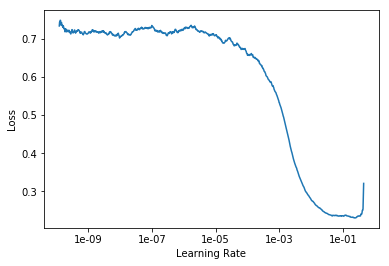

In [8]:
learn.lr_find(start_lr=1e-10,end_lr=1,num_it=1000)
learn.recorder.plot()

#### Run model

In [9]:
learn.fit_one_cycle(4,
                    1e-02,
                    wd=0.01, 
                    pct_start=0.01,
                    div_factor=40)

epoch,train_loss,valid_loss
1,0.215681,0.216927
2,0.211681,0.218124
3,0.209978,0.214504
4,0.202553,0.214670


#### Get predictions for validation set

In [10]:
# get predictions 
(val_preds, results) = learn.get_preds()

### Point spread vs. model predictions

In [11]:
# Get validation set pointspreads
game_spreads = nba.query('seas==2017')['spread'].values

# Add fav/dog to spread via H/A
ps_preds = (nba.query('seas == 2017').favored
            .apply(lambda x: -1 if x == 'A' else 1)) * game_spreads

#### Table definitions

Create a dataframe containing

+ `home_win` probability, `preds`
+ margin of victory, `results`
+ point spread, `ps`
+ predicted point spread `pred_spread`
+ Boolean was predicited spread closer than actual spread, `bl`

|Feature | Def
|--- |---
|preds | Model probability of home team win
|results | Margin of victory from home team perspective
|ps | Actual point spread for game
|pred_spread | Model predicted point spread based off WOO conversion chart
|pred_diff | Abs difference between result and prediction
|ps_diff | Abs diff between between result and point spread
|bl | Did the model get closer to the result than the point spread 

#### Build dataframe

In [12]:
game_preds_df = pd.DataFrame()
game_preds_df['preds'] = val_preds.numpy().ravel()
game_preds_df['results'] = nba.query('seas == 2017').mov.values
game_preds_df['ps'] = ps_preds.values

In [13]:
game_preds_df.head()

,preds,results,ps
0,0.315677,-19.0,-2.5
1,0.680949,5.0,4.0
2,0.620503,-2.0,2.5
3,0.954613,21.0,10.5
4,0.828488,3.0,6.0


In [14]:
spread_map.tail()

,PROBABILITY,spread
55,0.103411,13.5
56,0.096226,14.0
57,0.089490,14.5
58,0.083182,15.0
59,0.077282,15.5


In [15]:
game_preds_df = merge_closest(game_preds_df,
                              spread_map,
                              'preds',
                              'PROBABILITY',
                              ['spread'])

game_preds_df['spread'] = game_preds_df.spread * -1

In [16]:
game_preds_df.head()

,preds,results,ps,spread
0,0.315677,-19.0,-2.5,-5.0
1,0.680949,5.0,4.0,4.5
2,0.620503,-2.0,2.5,3.0
3,0.954613,21.0,10.5,15.5
4,0.828488,3.0,6.0,9.5


In [17]:
# rename from spread (which is in WOO set) to pred_spread
game_preds_df = game_preds_df.rename(index=str,columns={'spread':'pred_spread'})

In [18]:
# residuals
game_preds_df['pred_diff'] = abs(game_preds_df.results - game_preds_df.pred_spread)
game_preds_df['ps_diff'] = abs(game_preds_df.results - game_preds_df.ps)

In [19]:
# beat line
game_preds_df = (game_preds_df
                 .assign(bl = lambda x: x['pred_diff'] < x['ps_diff']))

In [21]:
game_preds_df.head(5)

,preds,results,ps,pred_spread,pred_diff,ps_diff,bl
0,0.315677,-19.0,-2.5,-5.0,14.0,16.5,True
1,0.680949,5.0,4.0,4.5,0.5,1.0,True
2,0.620503,-2.0,2.5,3.0,5.0,4.5,False
3,0.954613,21.0,10.5,15.5,5.5,10.5,True
4,0.828488,3.0,6.0,9.5,6.5,3.0,False


### Analysis

In [23]:
bl = game_preds_df.bl.mean()
print(f'Percentage of time model beats point spread {bl.round(3)}')

Percentage of time model beats point spread 0.422


In [25]:
mse = mean_squared_error(game_preds_df.ps, 
                   game_preds_df.results).round(3)
rmse = np.sqrt(mean_squared_error(game_preds_df.ps, 
                           game_preds_df.results)).round(3)

print(f' Point Spread Mean Squared Error {mse} \n Point Spread Root Mean Squared Error {rmse}')

 Point Spread Mean Squared Error 147.955 
 Point Spread Root Mean Squared Error 12.164


In [27]:
mse = mean_squared_error(game_preds_df.pred_spread, 
                   game_preds_df.results).round(3)
rmse = np.sqrt(mean_squared_error(game_preds_df.pred_spread, 
                           game_preds_df.results)).round(3)

print(f' Model Mean Squared Error {mse} \n Model Root Mean Squared Error {rmse}')

 Model Mean Squared Error 159.471 
 Model Root Mean Squared Error 12.628
